In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as torch

from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.torch_distributions import CondFoldedNormalDistribution

## Parameters go here

In [3]:
n_smps = 10000

# Setup true conditional Half Normal distributions

In [4]:
mu_f = ConstantRealFcn(init_vl=torch.tensor([1.0, 20.0, 3.0, 4.0]))
sigma_f = ConstantRealFcn(init_vl=torch.tensor([1, 2.0, 1.0, 2.0]))
true_dist = CondFoldedNormalDistribution(mu_f=mu_f, sigma_f=sigma_f)

## Generate samples

In [5]:
with torch.no_grad():
    x = torch.rand(n_smps, 2)
    smps = true_dist.sample(x)

## Visualize distributions of samples

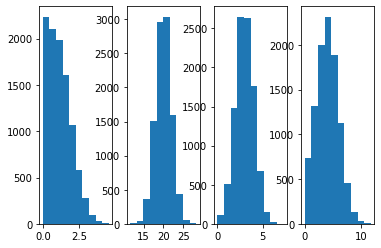

In [6]:
plot_smps = smps.numpy()
n_dists = plot_smps.shape[1]
for d_i in range(n_dists):
    plt.subplot(1,n_dists,d_i + 1)
    plt.hist(plot_smps[:,d_i])

## Fit a new distribution to the sample data 

In [37]:
mu_f_hat = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=40.0*np.ones(4), 
                                init_value=1.0*np.ones(4))
sigma_f_hat = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=40.0*np.ones(4), 
                                init_value=1.0*np.ones(4))

fit_dist = CondFoldedNormalDistribution(mu_f=mu_f_hat, sigma_f=sigma_f_hat)

In [42]:
optimizer = torch.optim.Adam(params=fit_dist.parameters(), lr=.001)
for it in range(2000):
    optimizer.zero_grad()
    nll = -1*torch.sum(fit_dist.log_prob(x=x, y=smps))
    nll.backward()
    optimizer.step()
    
    if it % 100 == 0:
        print('It: ' + str(it) + ', nll: '+ str(nll.detach().numpy()))

It: 0, nll: 80260.195
It: 100, nll: 73462.04
It: 200, nll: 70698.14
It: 300, nll: 68614.93
It: 400, nll: 67236.695
It: 500, nll: 66614.19
It: 600, nll: 66378.86
It: 700, nll: 66308.39
It: 800, nll: 66293.1
It: 900, nll: 66290.625
It: 1000, nll: 66290.35
It: 1100, nll: 66290.34
It: 1200, nll: 66290.35
It: 1300, nll: 66290.35
It: 1400, nll: 66290.32
It: 1500, nll: 66290.32
It: 1600, nll: 66290.32
It: 1700, nll: 66290.32
It: 1800, nll: 66290.32
It: 1900, nll: 66290.31


## Look at distributions of samples from fit functions

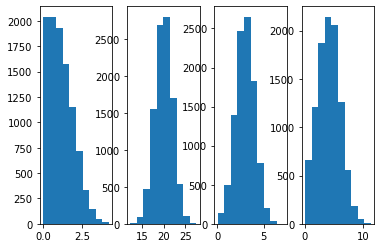

In [43]:
with torch.no_grad():
    fit_smps = fit_dist.sample(x)
    
plot_fit_smps = fit_smps.numpy()
n_dists = plot_fit_smps.shape[1]
for d_i in range(n_dists):
    plt.subplot(1,n_dists,d_i + 1)
    plt.hist(plot_fit_smps[:,d_i])

In [44]:
fit_dist.mu_f(x[0:1,:])

tensor([[ 1.0037, 20.0269,  3.0083,  4.0149]], grad_fn=<ExpandBackward>)

In [45]:
fit_dist.sigma_f(x[0:1,:])

tensor([[0.9787, 1.9804, 1.0070, 1.9997]], grad_fn=<ExpandBackward>)

## Fit a new distribution to the true one by minimize KL divergences

In [51]:
mu_f_kl = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=40.0*np.ones(4), 
                                init_value=1.0*np.ones(4))
sigma_f_kl = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=40.0*np.ones(4), 
                                init_value=1.0*np.ones(4))

dist_kl = CondFoldedNormalDistribution(mu_f=mu_f_kl, sigma_f=sigma_f_kl)

In [52]:
optimizer = torch.optim.Adam(params=dist_kl.parameters(), lr=.01)
for it in range(2000):
    optimizer.zero_grad()
    kl = torch.sum(dist_kl.kl(d_2=true_dist, x=x, smp=dist_kl.sample(x)))
    kl.backward()
    optimizer.step()
    
    if it % 100 == 0:
        print('It: ' + str(it) + ', kl: '+ str(kl.detach().numpy()))

It: 0, kl: 481184.8
It: 100, kl: 173156.16
It: 200, kl: 1032.9677
It: 300, kl: 48.722214
It: 400, kl: 3.4688325
It: 500, kl: -0.10107136
It: 600, kl: 0.40242815
It: 700, kl: 2.4700904
It: 800, kl: -0.5714617
It: 900, kl: -1.7074499
It: 1000, kl: 1.247571
It: 1100, kl: 4.5557375
It: 1200, kl: 1.6829295
It: 1300, kl: 2.9957886
It: 1400, kl: 1.5210519
It: 1500, kl: 1.5236053
It: 1600, kl: 0.053441525
It: 1700, kl: 1.6762981
It: 1800, kl: 1.6409211
It: 1900, kl: 1.8122659


## Look at distributions of samples from fit functions

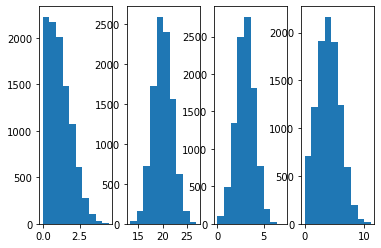

In [53]:
with torch.no_grad():
    fit_smps = dist_kl.sample(x)
    
plot_fit_smps = fit_smps.numpy()
n_dists = plot_fit_smps.shape[1]
for d_i in range(n_dists):
    plt.subplot(1,n_dists,d_i + 1)
    plt.hist(plot_fit_smps[:,d_i])

In [54]:
dist_kl.mu_f(x[0:1, :])

tensor([[ 0.9895, 19.9977,  2.9836,  3.9937]], grad_fn=<ExpandBackward>)

In [55]:
dist_kl.sigma_f(x[0:1, :])

tensor([[0.9914, 2.0036, 1.0019, 2.0015]], grad_fn=<ExpandBackward>)